# Deep dive on Overscan
    v1 -- Commissioning data
    v2 -- minisv2

In [1]:
%matplotlib inline

In [1]:
# imports
import os
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload
import glob

from scipy import signal

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from desispec import preproc

from bokeh import plotting
from bokeh import models

In [3]:
#exp_path = '/home/xavier/DESI/Commissioning/exposures'
exp_path = '/home/xavier/DESI/DESI_SCRATCH/'

In [4]:
night = '20191024'

# Methods

In [5]:
def add_gain(header, SP='sp2'):
    if SP=='sp2':
        header['GAINA'] = 1.21763880607
        header['GAINB'] = 1.26599257375
        header['GAINC'] = 1.37207665312
        header['GAIND'] = 1.28793077884

In [6]:
def get_oscan_col(rawimage, header, amp='A'):
    ov_col = preproc._parse_sec_keyword(header['BIASSEC'+amp])
    raw_overscan_col = rawimage[ov_col].copy()
    vals = []
    for row in range(raw_overscan_col.shape[0]):
        o, _ = preproc._overscan(raw_overscan_col[row,:])
        vals.append(o)
    overscan_col = np.array(vals)
    return overscan_col

In [7]:
def get_oscan_row(rawimage, header, amp='A'):
    ov_row_idx = preproc._parse_sec_keyword(header['ORSEC'+amp])
    raw_overscan_row = rawimage[ov_row_idx].copy()
    vals = []
    for col in range(raw_overscan_row.shape[1]):
        o, _ = preproc._overscan(raw_overscan_row[:,col])
        vals.append(o)
    overscan_row = np.array(vals)
    return overscan_row

# Find the right exposure

In [11]:
files = glob.glob(os.path.join(exp_path, night, '*','desi-*.fits.fz'))
files

['/home/xavier/DESI/DESI_SCRATCH/20191024/00020665/desi-00020665.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020664/desi-00020664.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020655/desi-00020655.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020675/desi-00020675.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020668/desi-00020668.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020669/desi-00020669.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020657/desi-00020657.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020652/desi-00020652.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020671/desi-00020671.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020651/desi-00020651.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020676/desi-00020676.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020658/desi-00020658.fits.fz',
 '/home/xavier/DESI/DESI_SCRATCH/20191024/00020667/desi-00020667.fits.fz',
 '/home/xavier/DESI/DESI_

In [15]:
for ifile in files:
    head = fits.open(ifile)[1].header
    #import pdb; pdb.set_trace()
    print(ifile, head['OBSTYPE'], head['EXPTIME'])

/home/xavier/DESI/DESI_SCRATCH/20191024/00020665/desi-00020665.fits.fz ARC 10.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020664/desi-00020664.fits.fz ARC 10.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020655/desi-00020655.fits.fz ZERO 0.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020675/desi-00020675.fits.fz FLAT 120.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020668/desi-00020668.fits.fz ARC 5.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020669/desi-00020669.fits.fz ARC 5.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020657/desi-00020657.fits.fz ZERO 0.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020652/desi-00020652.fits.fz ZERO 0.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020671/desi-00020671.fits.fz ARC 5.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020651/desi-00020651.fits.fz ZERO 0.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020676/desi-00020676.fits.fz FLAT 120.0
/home/xavier/DESI/DESI_SCRATCH/20191024/00020658/desi-00020658.fits.fz ZERO 0.0
/home/xavier/DESI/DESI_SCRATCH/20191024

# 120s exposure

In [16]:
iid = 20675
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/DESI_SCRATCH/20191024/00020675/desi-00020675.fits.fz'

In [19]:
hdulist = fits.open(ifile)
hdulist.info()

Filename: /home/xavier/DESI/DESI_SCRATCH/20191024/00020675/desi-00020675.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPS           1 CompImageHDU     58   (10,)   int16   
  2  Z3            1 CompImageHDU    137   (4256, 4194)   int16   
  3  R3            1 CompImageHDU    137   (4256, 4194)   int16   
  4  B3            1 CompImageHDU    137   (4232, 4162)   int16   
  5  SPECTCONS     1 BinTableHDU    119   1R x 42C   [K, K, 1PA(26), 1PA(15), D, 1PA(12), 1PA(19), 1PA(5), 1PA(4), 1PA(3), 1PA(4), 1PA(3), 1PA(5), 1PA(4), 1PA(8), 1PA(2), 1PA(6), 1PA(8), 1PA(2), 1PA(8), D, D, D, D, D, D, D, D, D, D, 1PA(3), 1PA(3), 1PA(3), 1PA(3), 1PA(3), 1PA(3), 1PA(7), 1PA(7), 1PA(7), 1PA(3), 1PA(3), 1PA(3)]   


## z3

In [20]:
z3_hdu_120 = hdulist['z3']

### Examine overscan_column

In [21]:
header = z3_hdu_120.header
rawimage = z3_hdu_120.data.astype(np.float64)

In [22]:
amp = 'A'

In [13]:
ov_col = preproc._parse_sec_keyword(header['BIASSEC'+amp])

In [14]:
raw_overscan_col = rawimage[ov_col].copy()
raw_overscan_col.shape

(2064, 64)

In [15]:
vals = []
for row in range(raw_overscan_col.shape[0]):
    o, _ = preproc._overscan(raw_overscan_col[row,:])
    vals.append(o)
overscan_col = np.array(vals)
overscan_col.shape

(2064,)

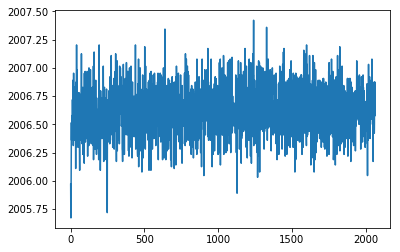

In [16]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_col)
plt.show()

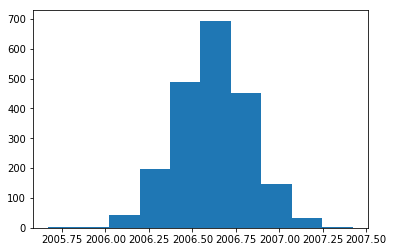

In [17]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_col)
plt.show()

In [18]:
mean, med_sn2, stddev = sigma_clipped_stats(overscan_col,sigma_lower=3.0,sigma_upper=3.0)
stddev

0.2080538536241746

### Let's try a savgol

In [19]:
oscol_sub = signal.savgol_filter(overscan_col, 65, 5)

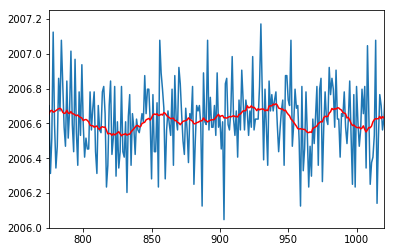

In [20]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_col)
ax.plot(oscol_sub, 'r-')
ax.set_xlim(775, 1020)
ax.set_ylim(2006., 2007.25)
plt.show()

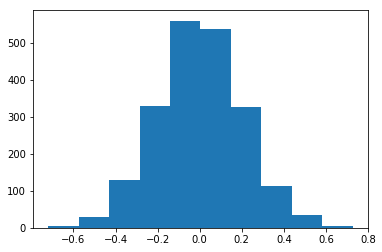

In [21]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_col-oscol_sub)
plt.show()

In [22]:
mean, med_sn2, stddev_sub = sigma_clipped_stats(overscan_col-oscol_sub,sigma_lower=3.0,sigma_upper=3.0)
stddev_sub

0.19939938942624164

## Overscan row

In [23]:
ov_row_idx = preproc._parse_sec_keyword(header['ORSEC'+amp])

In [24]:
raw_overscan_row = rawimage[ov_row_idx].copy()
raw_overscan_row.shape

(32, 2057)

In [25]:
vals = []
for col in range(raw_overscan_row.shape[1]):
    o, _ = preproc._overscan(raw_overscan_row[:,col])
    vals.append(o)
overscan_row = np.array(vals)
overscan_row.shape

(2057,)

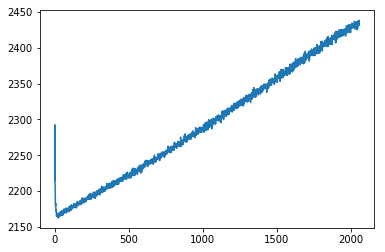

In [26]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_row)
plt.show()

### Sobolev

In [27]:
osrow_sub = signal.savgol_filter(overscan_row, 65, 5)

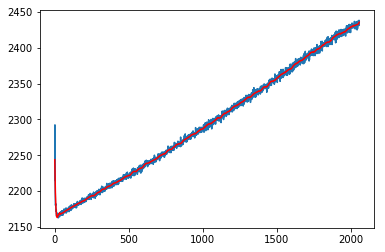

In [28]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_row)
ax.plot(osrow_sub, 'r-')
plt.show()

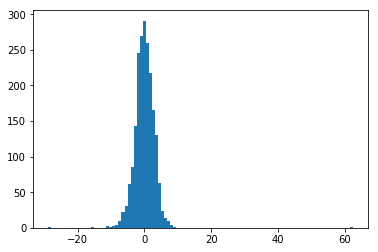

2.598601353934941

In [29]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_row-osrow_sub, bins=100)
plt.show()
# Stats
mean, med_sn2, stddev_sub_row = sigma_clipped_stats(overscan_row-osrow_sub,sigma_lower=3.0,sigma_upper=3.0)
stddev_sub_row

# Explore a zero image

In [30]:
night = '20190620'
iid = 16394
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/Commissioning/exposures/20190620/00016394/desi-00016394.fits.fz'

In [31]:
hdulist = fits.open(ifile)

In [32]:
z2_zero = hdulist['z2']

In [33]:
header = z2_zero.header
rawimage = z2_zero.data.astype(np.float64)

## Overscan col

In [34]:
oscan_col = get_oscan_col(rawimage, header)

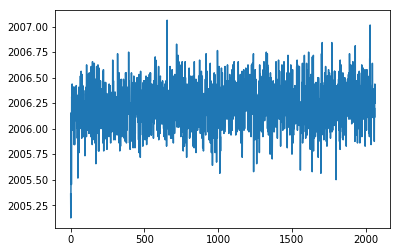

In [35]:
plt.clf()
ax = plt.gca()
ax.plot(oscan_col)
plt.show()

## Overscan row

In [36]:
oscan_row = get_oscan_row(rawimage, header)

ERROR:preproc.py:84:_overscan: error in sigma clipping for overscan measurement, return result without clipping


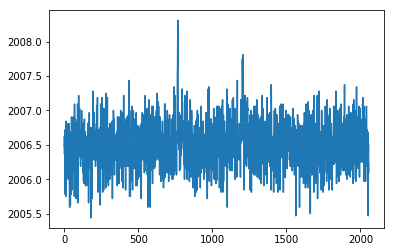

In [37]:
plt.clf()
ax = plt.gca()
ax.plot(oscan_row)
plt.show()

# Let's process with savgol

In [3]:
reload(preproc)
img_zero = preproc.preproc(rawimage, header, None, bias=False, pixflat=False, mask=False, 
                      nocrosstalk=True, ccd_calibration_filename=False, dark=False)

NameError: name 'rawimage' is not defined

In [39]:
img_zero.pix.shape

(4128, 4114)

In [40]:
#from pypeit import ginga
#ginga.show_image(img_zero.pix)

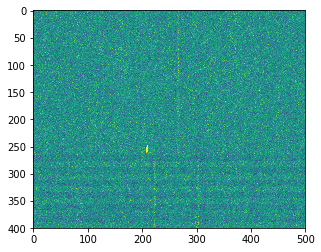

In [41]:
vmin, vmax = -9., 9.
plt.clf()
#plt.figure(figsize=(13,7))
plt.imshow(img_zero.pix[1800:2200,500:1000], vmin=vmin, vmax=vmax)
plt.show()

----

# Image 20675, r3

In [4]:
#night = '20190627'
#iid = 16727
iid = 20675
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

NameError: name 'exp_path' is not defined

In [5]:
hdulist = fits.open(ifile)
r3 = hdulist['r3']

NameError: name 'ifile' is not defined

In [6]:
reload(preproc)
img_r3 = preproc.preproc(r3.data, r3.header, None, bias=False, pixflat=False, mask=False, 
                      nocrosstalk=True, ccd_calibration_filename=False, dark=False)

NameError: name 'r3' is not defined

In [27]:
from pypeit import ginga
ginga.show_image(img_r3.pix)

(<ginga.util.grc.RemoteClient at 0x7fcde6ff5160>,
 <ginga.util.grc._channel_proxy at 0x7fcde6ff50f0>)

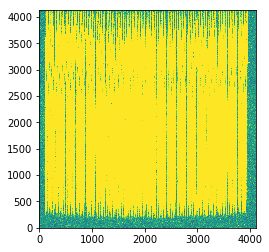

In [29]:
vmin, vmax = -9., 9.
plt.clf()
#plt.figure(figsize=(13,7))
plt.imshow(img_r3.pix, vmin=vmin, vmax=vmax, origin='lower')
plt.show()

----

# Bias

In [30]:
iid = 20655
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/DESI_SCRATCH/20191024/00020655/desi-00020655.fits.fz'

In [32]:
hdulist = fits.open(ifile)
#hdulist.info()
z3 = hdulist['z3']

In [33]:
reload(preproc)
img_z3 = preproc.preproc(z3.data, z3.header, None, bias=False, pixflat=False, mask=False, 
                      nocrosstalk=True, ccd_calibration_filename=False, dark=False)

INFO:preproc.py:496:preproc: nrows in overscan=2064
INFO:preproc.py:510:preproc: Subtracting average overscan for amplifier A of camera z3
INFO:preproc.py:518:preproc: Median rdnoise and overscan= 1.657835 1962.513169
INFO:preproc.py:552:preproc: Measured readnoise for AMP A = 1.657835
INFO:preproc.py:496:preproc: nrows in overscan=2064
INFO:preproc.py:510:preproc: Subtracting average overscan for amplifier B of camera z3
INFO:preproc.py:518:preproc: Median rdnoise and overscan= 1.537479 1994.585006
INFO:preproc.py:552:preproc: Measured readnoise for AMP B = 1.537479
INFO:preproc.py:496:preproc: nrows in overscan=2064
INFO:preproc.py:510:preproc: Subtracting average overscan for amplifier C of camera z3
INFO:preproc.py:518:preproc: Median rdnoise and overscan= 1.703619 1978.024611
INFO:preproc.py:552:preproc: Measured readnoise for AMP C = 1.703619
INFO:preproc.py:496:preproc: nrows in overscan=2064
INFO:preproc.py:510:preproc: Subtracting average overscan for amplifier D of camera z3


In [34]:
ginga.show_image(img_z3.pix)

(<ginga.util.grc.RemoteClient at 0x7fcde7026828>,
 <ginga.util.grc._channel_proxy at 0x7fcdea92d780>)

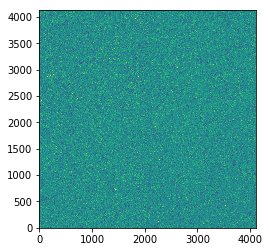

In [35]:
vmin, vmax = -9., 9.
plt.clf()
#plt.figure(figsize=(13,7))
plt.imshow(img_z3.pix, vmin=vmin, vmax=vmax, origin='lower')
plt.show()

----

# Exploring yet another bias frame : z3-00022217

In [12]:
def set_fontsize(p, fsz):
    '''
    Parameters
    ----------
    ax : Bokeh plot class
    fsz : float
      Font size
    '''
    p.xaxis.axis_label_text_font_size = '{:d}pt'.format(fsz)
    p.xaxis.major_label_text_font_size = "{:d}pt".format(fsz)
    #
    p.yaxis.axis_label_text_font_size = '{:d}pt'.format(fsz)
    p.yaxis.major_label_text_font_size = "{:d}pt".format(fsz)

## Load em

In [1]:
path = '/home/xavier/DESI/DESI_SCRATCH/Commissioning/Overscan/'

In [37]:
hdu_sav = fits.open(os.path.join(path, 'preproc-z3-00022217_savgol.fits'))
data_sav = hdu_sav[0].data
hdu_sav.info()

Filename: /home/xavier/DESI/DESI_SCRATCH/Commissioning/Overscan/preproc-z3-00022217_savgol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  IMAGE         1 PrimaryHDU     165   (4114, 4128)   float32   
  1  IVAR          1 ImageHDU        10   (4114, 4128)   float32   
  2  MASK          1 CompImageHDU     10   (4114, 4128)   int16   
  3  READNOISE     1 ImageHDU        10   (4114, 4128)   float32   
  4  FIBERMAP      1 BinTableHDU    230   500R x 73C   [K, K, K, K, K, D, D, D, D, K, K, 4A, J, D, K, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 1A, J, K, K, J, K, J, J, J, J, J, 3A, E, E, E, K, B, I, D, D, E, E, E, E, E, E, J, J]   


In [38]:
hdu_no = fits.open(os.path.join(path, 'preproc-z3-00022217_nosavgol.fits'))
data_no = hdu_no[0].data

## Compare em

In [39]:
med_sav = np.median(data_sav[500:1000,:],axis=0)
med_no = np.median(data_no[500:1000,:],axis=0)

In [40]:
med_sav.size

4114

In [41]:
# Plot
plotting.output_notebook()

p = plotting.figure(title='Median Overscan', x_axis_label='Column',
                   y_axis_label='Counts')

p.line(np.arange(4114), med_no, legend='No Sav Gol', line_width=2, color='red')
p.line(np.arange(4114), med_sav, legend='Sav Gol', line_width=2, color='blue')
#p.line(np.arange(4114), med_master, legend='Master', line_width=2, color='green')


p.legend.location = "bottom_left"

set_fontsize(p, 16)

plotting.show(p)

Loading BokehJS ...

----

# MiniSV2

In [2]:
# ginga
from pypeit import ginga

In [3]:
os.environ['DESI_SPECTRO_CALIB'] = '/home/xavier/DESI/spectro/desi_spectro_calib'

## Load

In [4]:
exp_path = '/scratch/DESI_SCRATCH/minisv2/data'

In [5]:
night = '20200304'
iid = 53018
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile, os.path.isfile(ifile)

('/scratch/DESI_SCRATCH/minisv2/data/20200304/00053018/desi-00053018.fits.fz',
 True)

In [6]:
hdulist = fits.open(ifile)
hdulist.info()

Filename: /scratch/DESI_SCRATCH/minisv2/data/20200304/00053018/desi-00053018.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPEC          1 CompImageHDU    228   (10,)   int16   
  2  Z4            1 CompImageHDU    136   (4256, 4194)   int16   
  3  R4            1 CompImageHDU    136   (4256, 4194)   int16   
  4  B4            1 CompImageHDU    136   (4232, 4162)   int16   
  5  Z9            1 CompImageHDU    136   (4256, 4194)   int16   
  6  R9            1 CompImageHDU    136   (4256, 4194)   int16   
  7  B9            1 CompImageHDU    136   (4232, 4162)   int16   
  8  Z6            1 CompImageHDU    136   (4256, 4194)   int16   
  9  R6            1 CompImageHDU    136   (4256, 4194)   int16   
 10  B6            1 CompImageHDU    136   (4232, 4162)   int16   
 11  Z7            1 CompImageHDU    136   (4256, 4194)   int16   
 12  R7            1 CompImageHDU    136   (4256, 4194)   int16   
 13  

In [7]:
camera = 'z3'
hdu = hdulist[camera.upper()]
#r4_calib_file = os.path.join(os.getenv('DESI_SPECTRO_CALIB'), 'spec', 'sm1', 'sm1-r.yaml')\n",
smnum = hdu.header['SPECGRPH']
smnum = hdu.header['SPECID']
#calib_file = os.path.join(os.getenv('DESI_SPECTRO_CALIB'), 'spec', 'sp{}'.format(smnum),
#                         '{}{}.yaml'.format(camera[0],smnum))
calib_file = os.path.join(os.getenv('DESI_SPECTRO_CALIB'), 'spec', 'sm{}'.format(smnum),
                         'sm{}-{}.yaml'.format(smnum, camera[0]))

In [8]:
hdu.header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4256 / length of original image axis                  
NAXIS2  =                 4194 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
EXTNAME = 'Z3      '                                                            
INSTRUME= 'DESI    '           / Instrument name                                
PROCTYPE= 'RAW     '           / Data processing level                          
PRODTYPE= 'image   '        

## Default

In [9]:
from desispec import calibfinder

In [44]:
reload(calibfinder)
reload(preproc)
img_def = preproc.preproc(hdu.data, hdu.header, hdulist[0].header, bias=True, pixflat=False, mask=False,
                        nocrosstalk=True, ccd_calibration_filename=calib_file, dark=False, flag_savgol=False)

INFO:preproc.py:310:get_calibration_image: Using BIAS /home/xavier/DESI/spectro/desi_spectro_calib/ccd/bias-sm6-z-20191021.fits
INFO:preproc.py:431:preproc: subtracting bias
INFO:preproc.py:508:preproc: Using GAINA=1.445 from calibration data
INFO:preproc.py:520:preproc: Using SATURLEVA=52000.0 from calibration data
INFO:preproc.py:540:preproc: nrows in overscan=2064
INFO:preproc.py:554:preproc: Subtracting average overscan for amplifier A of camera z3
INFO:preproc.py:562:preproc: Median rdnoise and overscan= 2.398503 1968.138610
INFO:preproc.py:596:preproc: Measured readnoise for AMP A = 2.398503
INFO:preproc.py:508:preproc: Using GAINB=1.481 from calibration data
INFO:preproc.py:520:preproc: Using SATURLEVB=23000.0 from calibration data
INFO:preproc.py:540:preproc: nrows in overscan=2064
INFO:preproc.py:554:preproc: Subtracting average overscan for amplifier B of camera z3
INFO:preproc.py:562:preproc: Median rdnoise and overscan= 2.368260 2000.058723
INFO:preproc.py:596:preproc: Meas

In [45]:
ginga.show_image(img_def.pix, chname='default')

(<ginga.util.grc.RemoteClient at 0x7f9e8a2cdcf8>,
 <ginga.util.grc._channel_proxy at 0x7f9e89dd7048>)

## Savgol recipe

In [47]:
reload(preproc)
img_savgol = preproc.preproc(hdu.data, hdu.header, hdulist[0].header, bias=True, pixflat=False, mask=False,
                        nocrosstalk=True, ccd_calibration_filename=calib_file, dark=False, 
                          overscan_per_row=True, flag_savgol=True)

INFO:preproc.py:310:get_calibration_image: Using BIAS /home/xavier/DESI/spectro/desi_spectro_calib/ccd/bias-sm6-z-20191021.fits
INFO:preproc.py:431:preproc: subtracting bias
INFO:preproc.py:508:preproc: Using GAINA=1.445 from calibration data
INFO:preproc.py:520:preproc: Using SATURLEVA=52000.0 from calibration data
INFO:preproc.py:540:preproc: nrows in overscan=2064
INFO:preproc.py:544:preproc: Subtracting overscan per row for amplifier A of camera z3
INFO:preproc.py:562:preproc: Median rdnoise and overscan= 2.372845 1968.138585
INFO:preproc.py:596:preproc: Measured readnoise for AMP A = 2.372845
INFO:preproc.py:609:preproc: Using savgol
Window: 15
INFO:preproc.py:508:preproc: Using GAINB=1.481 from calibration data
INFO:preproc.py:520:preproc: Using SATURLEVB=23000.0 from calibration data
INFO:preproc.py:540:preproc: nrows in overscan=2064
INFO:preproc.py:544:preproc: Subtracting overscan per row for amplifier B of camera z3
INFO:preproc.py:562:preproc: Median rdnoise and overscan= 2

In [29]:
ginga.show_image(img_savgol.pix, chname='savgol')

(<ginga.util.grc.RemoteClient at 0x7f9eab44ef98>,
 <ginga.util.grc._channel_proxy at 0x7f9eab44ee48>)

## Compare

In [48]:
slc = slice(3000,3500)
prof_def=np.median(img_def.pix[slc],axis=0)
#prof_both = np.median(img_full.pix[2070:4000], axis=0)
prof_gol = np.median(img_savgol.pix[slc], axis=0)

plotting.output_notebook()

p = plotting.figure(title='Overscan comparisons', x_axis_label='column',
                   y_axis_label='electrons', plot_width=800)#, x_range=(0,-90))

p.line(np.arange(prof_def.size), prof_def, legend='default')#, line_width=2)
#p.line(np.arange(prof_row.size), prof_both, legend='per_row, savgol', color='green')
p.line(np.arange(prof_gol.size), prof_gol, legend='savgol', color='red')
#p.line(z, v, legend='v', line_width=2, color='red')

p.legend.location = "top_right"
#set_fontsize(p, 16)\n",

plotting.show(p)

Loading BokehJS ...

In [23]:
D = (slice(2100,4000), slice(2100,4000))

In [25]:
o_def, r_def = preproc._overscan(img_def.pix[D])
o_def, r_def

(0.11901996267588888, 3.0063307525240823)

In [26]:
o_gol, r_gol = preproc._overscan(img_savgol.pix[D])
o_gol, r_gol

(0.13473042842573665, 2.989119626330067)

In [49]:
np.std(prof_def[:2000:]), np.std(prof_gol[:2000])

(0.3369774313385617, 0.31887521356008103)

In [51]:
img_savgol.pix.shape

(4128, 4114)